We covered the idea of simulating an arbitrary transfer function system in [a previous notebook](../1_Dynamics/5_Complex_system_dynamics/Simulation%20of%20arbitrary%20transfer%20functions.ipynb). What happens if we have to simulate a controller (specified as a transfer function) and a system specified by differential equations together?

# Nonlinear tank system

Let's take the classic tank system, with a square root flow relationship on the outflow and a nonlinear valve relationship.

<img src="../assets/tanksystem.png">

\begin{align}
      \frac{dV}{dt} &= (F_{in} - F_{out}) \\
      h &= \frac{V}{A} \\
      f(x) &= \alpha^{x - 1} \\
      F_{out} &= K f(x) \sqrt{h} \\
\end{align}

In [1]:
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

Parameters

In [2]:
A = 2
alpha = 20
K = 2

Initial conditions (notice I'm not starting at steady state)

In [3]:
Fin = 1
h = 1
V = A*h
x0 = x = 0.7

Valve characterisitic

In [4]:
def f(x):
    return alpha**(x - 1)

Integration time

In [5]:
ts = numpy.linspace(0, 100, 1000)
dt = ts[1]

Notice that I have reordered the equations here so that they can be evaluated in order to find the volume derivative.

In [6]:
hs = []
for t in ts:
    h = V/A
    Fout = K*f(x)*numpy.sqrt(h)
    dVdt = Fin - Fout
    V += dVdt*dt
    
    hs.append(h)

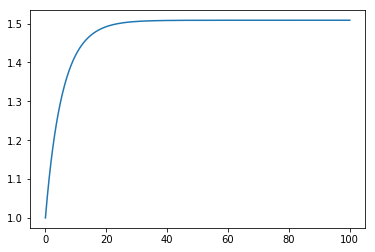

In [7]:
plt.plot(ts, hs)

# PI Control


Now we can include a controller controlling the level by manipulating the valve fraction

In [8]:
import scipy.signal

Let's do a PI controller:

$$ G_c = K_c(1 + \frac{1}{\tau_I s}) = \frac{K_C \tau_I s + K_Cs^0}{\tau_I s + 0s^0} $$

In [9]:
Kc = -1
tau_i = 5

In versions of scipy < 1.0, `Gc` would automatically have a `.A` attribute. After 1.0, we need to convert to state space explicitly with `.to_ss()`.

In [10]:
Gc = scipy.signal.lti([Kc*tau_i, Kc], [tau_i, 0]).to_ss()

In [11]:
hsp = 1.3

In [12]:
V = 1
hs = []
xc = numpy.zeros([Gc.A.shape[0], 1])
for t in ts:
    h = V/A
    e = hsp - h  # we cheat a little here - the level we use to calculate the error is from the previous time step
    
    # e is in the input to the controller, yc is the output
    dxcdt = Gc.A.dot(xc) + Gc.B.dot(e)
    yc = Gc.C.dot(xc) + Gc.D.dot(e)
    
    x = x0 + yc[0,0]  # x0 is the controller bias
    
    Fout = K*f(x)*numpy.sqrt(h)
    dVdt = Fin - Fout
    
    V += dVdt*dt
    xc += dxcdt*dt
    
    hs.append(h)

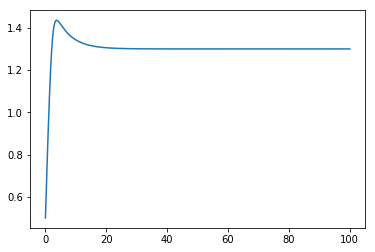

In [13]:
plt.plot(ts, hs)